### Specifying the data analytic question
Build a clustering model that groups images based on similarities in the vegetation cover.

### Model Approach
This notebook implements autoencoders plus KMeans to extract important features from a set of RGB satellite images and clusters them based on similarity of the extracted features. An autoencoder works by leveraging the power of neural networks for representation learning to extract the important features while eliminating noise by implementing a bottleneck. The learnt features are used to reconstruct the data into its original form which ensures important data is not lost. In this approach, the learnt features are passed into a clustering layer and images with similar features are grouped together.

### Model Caveat
Since this is an unsupervised learning approach, the image clusters are not reflective of any specific vegetation class unless they are manually annotated. Additionally, training of the model is only done on the autoencoder but not on the clustering layer as I couldn't come up with an appropriate loss function for the clusters.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# set seed for reproducibility
import numpy as np
np.random.seed(10)

In [3]:
# importing required libraries
import os
import cv2
from time import time
import numpy as np
import keras.backend as K
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.engine.topology import Layer, InputSpec
from keras.layers import Dense, Input
from keras.models import Model
from keras.optimizers import SGD
from keras import callbacks
from keras.initializers import VarianceScaling
from sklearn.cluster import KMeans

In [4]:
# set path to sentinel 2 images
path = '/content/drive/MyDrive/dl_aoi/Kenya_AOI_154/Kenya_AOI_154_PNG/kenya_before_png'

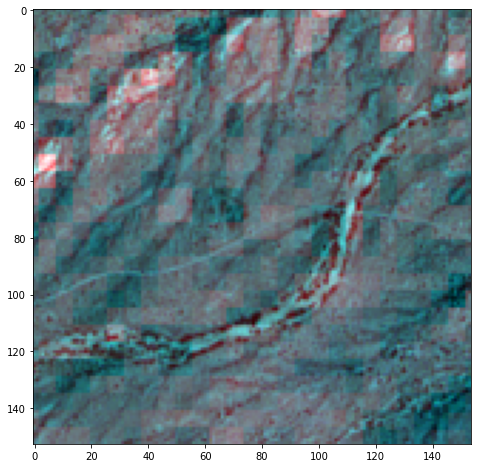

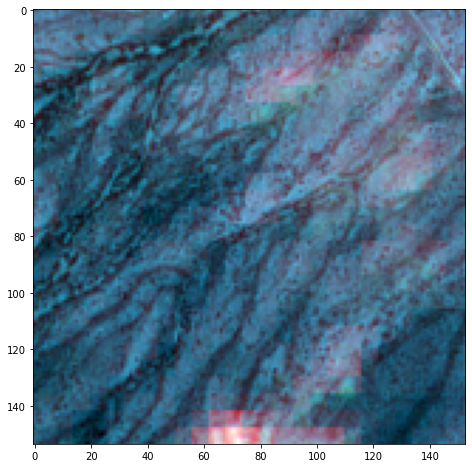

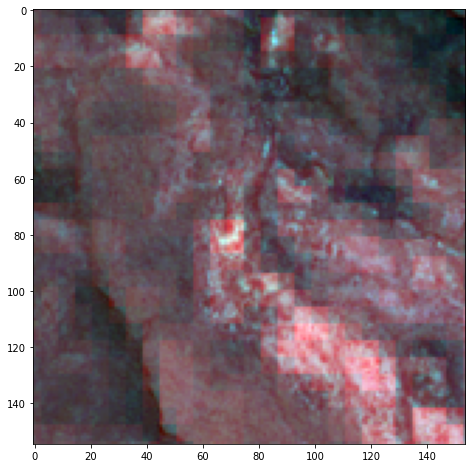

In [5]:
# preview images
i = 0
for img in os.listdir(path):
  img_array = cv2.imread(os.path.join(path, img))
  plt.figure(figsize=(8,8))
  plt.imshow(img_array)
  i += 1
  if i>2:
    break

In [6]:
# Upload image arrays
dsize = (153,153)
before_images = []
file_names = []

files = [file for file in os.listdir(path)]
for file in files:
  img_array = cv2.imread(os.path.join(path, file))
  img_ = cv2.resize(img_array, dsize)
  before_images.append(img_)
  file_names.append(file)

In [7]:
n_clusters = 6 # clusters given by KRC

In [8]:
# preprocess images
x = np.array(before_images)
x = x.reshape((x.shape[0], -1))
x = np.divide(x, 255.)
x.shape

(261, 70227)

In [9]:
dims = [x.shape[-1], 500, 500, 2000, 10]
init = VarianceScaling(scale=1. / 3., mode='fan_in',
                           distribution='uniform')
pretrain_optimizer = SGD(lr=0.1, momentum=0.9)
pretrain_epochs = 600
batch_size = 256
save_dir = '/content/drive/MyDrive/models'

In [10]:
# create autoencoder
def autoencoder(dims, act='relu', init='glorot_uniform'):
    """
    Fully connected auto-encoder model, symmetric.
    Arguments:
        dims: list of number of units in each layer of encoder. dims[0] is input dim, dims[-1] is units in hidden layer.
            The decoder is symmetric with encoder. So number of layers of the auto-encoder is 2*len(dims)-1
        act: activation, not applied to Input, Hidden and Output layers
    return:
        (ae_model, encoder_model), Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1
    # input
    input_img = Input(shape=(dims[0],), name='input')
    x = input_img
    # internal layers in encoder
    for i in range(n_stacks-1):
        x = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(x)

    # hidden layer
    encoded = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(x)  # hidden layer, features are extracted from here

    x = encoded
    # internal layers in decoder
    for i in range(n_stacks-1, 0, -1):
        x = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(x)

    # output
    x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
    decoded = x
    return Model(inputs=input_img, outputs=decoded, name='AE'), Model(inputs=input_img, outputs=encoded, name='encoder')

In [11]:
autoencoder, encoder = autoencoder(dims, init=init)

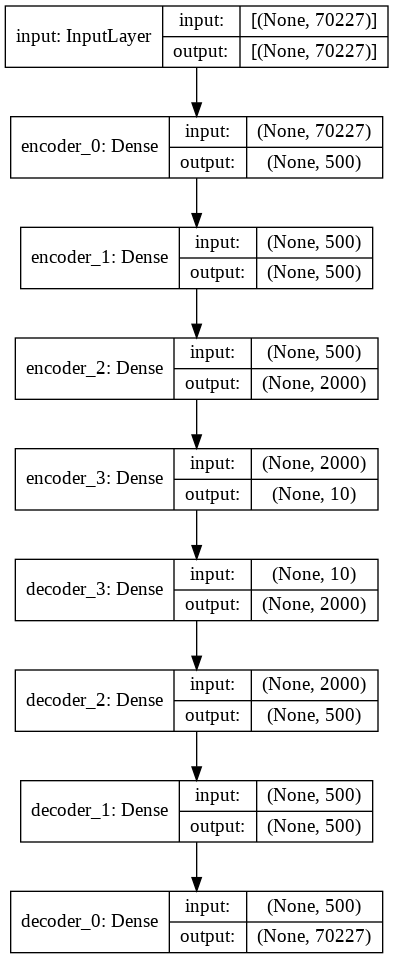

In [12]:
# plot layers in autoencoder
from keras.utils import plot_model
plot_model(autoencoder, to_file='autoencoder.png', show_shapes=True)
from IPython.display import Image
Image(filename='autoencoder.png')

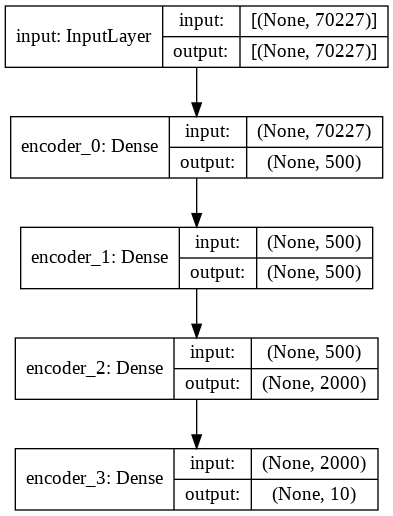

In [13]:
# examine layers in the encoder
from keras.utils import plot_model
plot_model(encoder, to_file='encoder.png', show_shapes=True)
from IPython.display import Image
Image(filename='encoder.png')

In [14]:
# train autoencoder and save weights
autoencoder.compile(optimizer=pretrain_optimizer, loss='mse')
autoencoder.fit(x, x, batch_size=batch_size, epochs=pretrain_epochs) #, callbacks=cb)
# autoencoder.save_weights(save_dir + '/sat0.1_weights.h5')

Epoch 1/600
2/2 [==============================] - 2s 21ms/step - loss: 0.1698
Epoch 2/600
2/2 [==============================] - 0s 19ms/step - loss: 0.1692
Epoch 3/600
2/2 [==============================] - 0s 18ms/step - loss: 0.1689
Epoch 4/600
2/2 [==============================] - 0s 17ms/step - loss: 0.1692
Epoch 5/600
2/2 [==============================] - 0s 18ms/step - loss: 0.1697
Epoch 6/600
2/2 [==============================] - 0s 18ms/step - loss: 0.1699
Epoch 7/600
2/2 [==============================] - 0s 18ms/step - loss: 0.1691
Epoch 8/600
2/2 [==============================] - 0s 17ms/step - loss: 0.1694
Epoch 9/600
2/2 [==============================] - 0s 16ms/step - loss: 0.1695
Epoch 10/600
2/2 [==============================] - 0s 17ms/step - loss: 0.1693
Epoch 11/600
2/2 [==============================] - 0s 16ms/step - loss: 0.1690
Epoch 12/600
2/2 [==============================] - 0s 18ms/step - loss: 0.1693
Epoch 13/600
2/2 [==============================]

In [15]:
autoencoder.save_weights(save_dir + '/sat0.1_weights.h5')

In [16]:
# load trained model weights
autoencoder.load_weights(save_dir + '/sat0.1_weights.h5')

In [17]:
# add clustering layer to autoencoder
class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.

    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: degrees of freedom parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(name='clusters', shape=(self.n_clusters, input_dim), initializer='glorot_uniform')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
         Measure the similarity between embedded point z_i and centroid µ_j.
                 q_ij = 1/(1+dist(x_i, µ_j)^2), then normalize it.
                 q_ij can be interpreted as the probability of assigning sample i to cluster j.
                 (i.e., a soft assignment)
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) # Make sure each sample's 10 values add up to 1.
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [18]:
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input, outputs=clustering_layer)

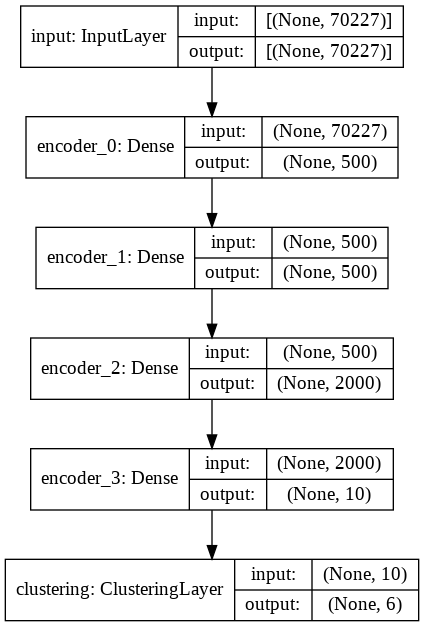

In [19]:
# examine model with clustering layer as final layer
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)
from IPython.display import Image
Image(filename='model.png')

In [20]:
# set model parameters
model.compile(optimizer=SGD(0.01, 0.9), loss='kld')

In [21]:
# implement kmeans on output from encoder
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(x))

In [22]:
# set cluster centers as weights for clustering layer
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

In [23]:
# make predictions
clus = model.predict(x)
clusters_classes = clus.argmax(1)

In [24]:
# save images per cluster
cluster_path = '/content/drive/My Drive/Clusters_6/'

for c in range(n_clusters):
  cname = 'cluster_'+ str(c)
  cp = os.path.join(cluster_path, cname)
  if not os.path.exists(cp):
    os.mkdir(cp)

for fn, cluster in zip(file_names, clusters_classes):
    image = cv2.imread(os.path.join(path, fn))
    cv2.imwrite(cluster_path+'cluster_'+str(cluster)+'/'+fn, image)

### Visualizing the Clusters

Number of images in this cluster_0 = 57


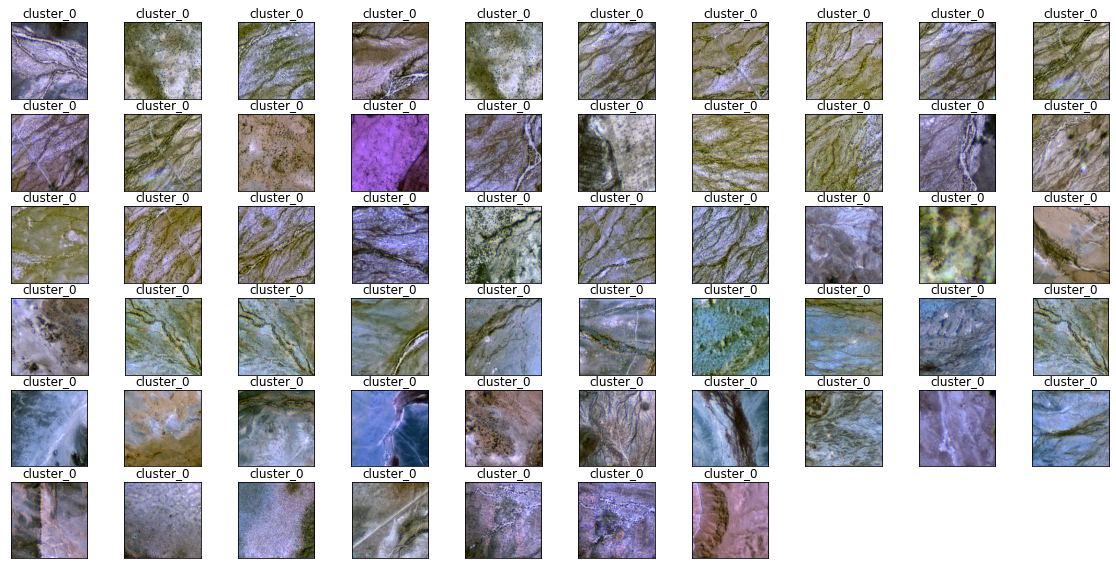

In [25]:
c_path = '/content/drive/My Drive/Clusters_6/cluster_0/'
fig = plt.figure(figsize=(20,20))

images_0 = [file for file in os.listdir(c_path)]

print("Number of images in this cluster_0 =", len(images_0))

for cnt, data in enumerate(images_0):
#     print(data)
    y = fig.add_subplot(12, 10, cnt+1)
    img = mpimg.imread(c_path+data)
    y.imshow(img)
    plt.title('cluster_0')
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)

Number of images in this cluster_1 = 54


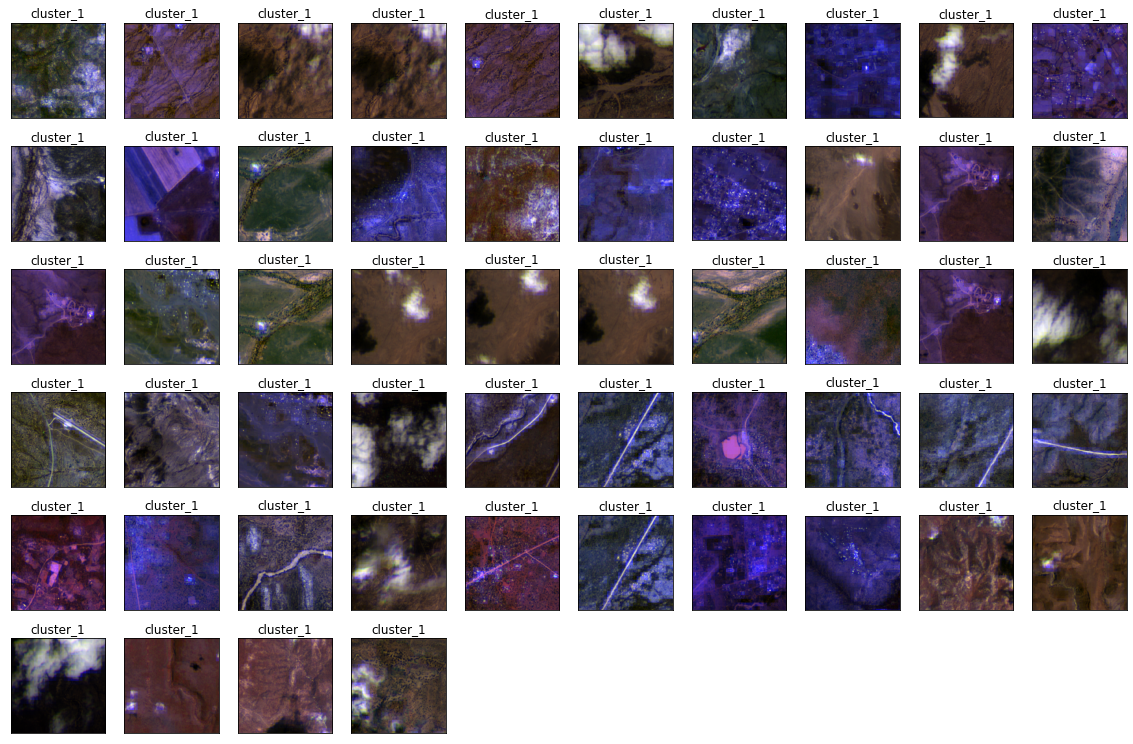

In [26]:
c_path = '/content/drive/My Drive/Clusters_6/cluster_1/'
fig = plt.figure(figsize=(20,20))

images_1 = [file for file in os.listdir(c_path)]

print("Number of images in this cluster_1 =", len(images_1))

for cnt, data in enumerate(images_1):
#     print(data)
    y = fig.add_subplot(9, 10, cnt+1)
    img = mpimg.imread(c_path+data)
    y.imshow(img)
    plt.title('cluster_1')
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)

Number of images in cluster_2 = 53


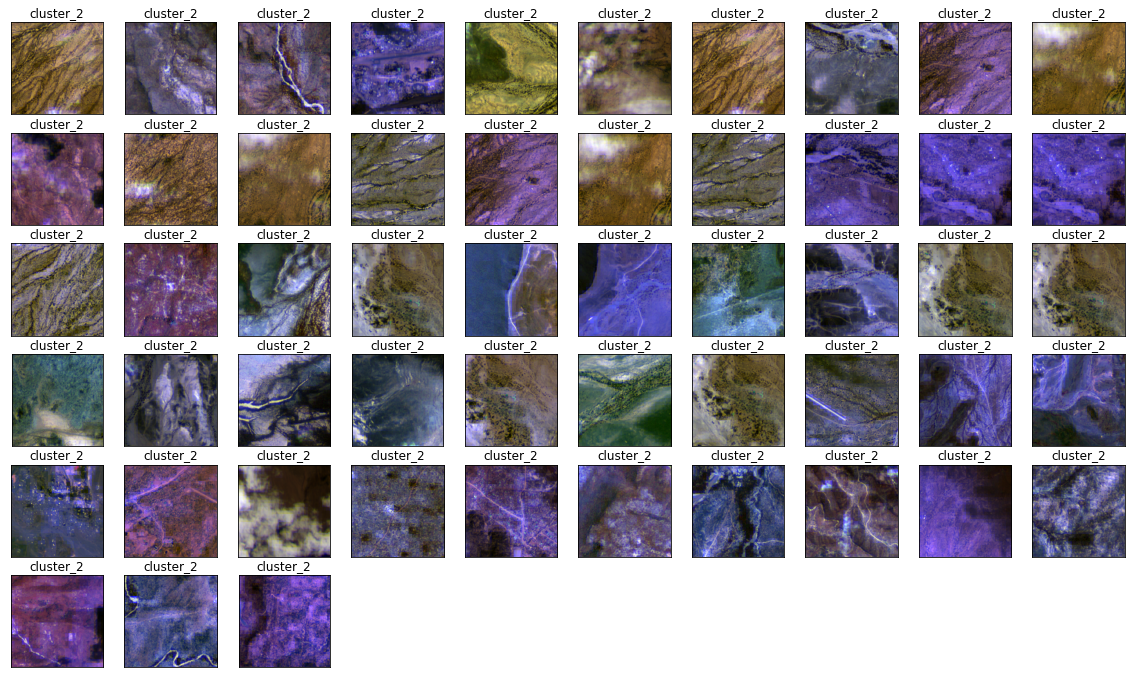

In [27]:
c_path = '/content/drive/My Drive/Clusters_6/cluster_2/'
fig = plt.figure(figsize=(20,20))

images_2 = [file for file in os.listdir(c_path)]

print("Number of images in cluster_2 =", len(images_2))

for cnt, data in enumerate(images_2):
#     print(data)
    y = fig.add_subplot(10, 10, cnt+1)
    img = mpimg.imread(c_path+data)
    y.imshow(img)
    plt.title('cluster_2')
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)

Number of images in cluster_3 = 15


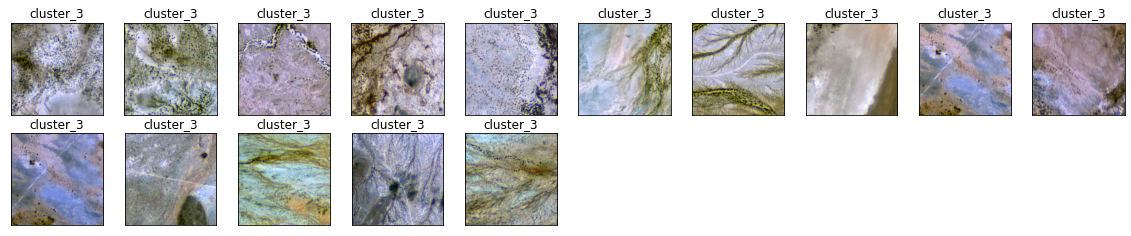

In [28]:
c_path = '/content/drive/My Drive/Clusters_6/cluster_3/'
fig = plt.figure(figsize=(20,20))

images_3 = [file for file in os.listdir(c_path)]

print("Number of images in cluster_3 =", len(images_3))

for cnt, data in enumerate(images_3):
#     print(data)
    y = fig.add_subplot(10, 10, cnt+1)
    img = mpimg.imread(c_path+data)
    y.imshow(img)
    plt.title('cluster_3')
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)

Number of images in cluster_4 = 37


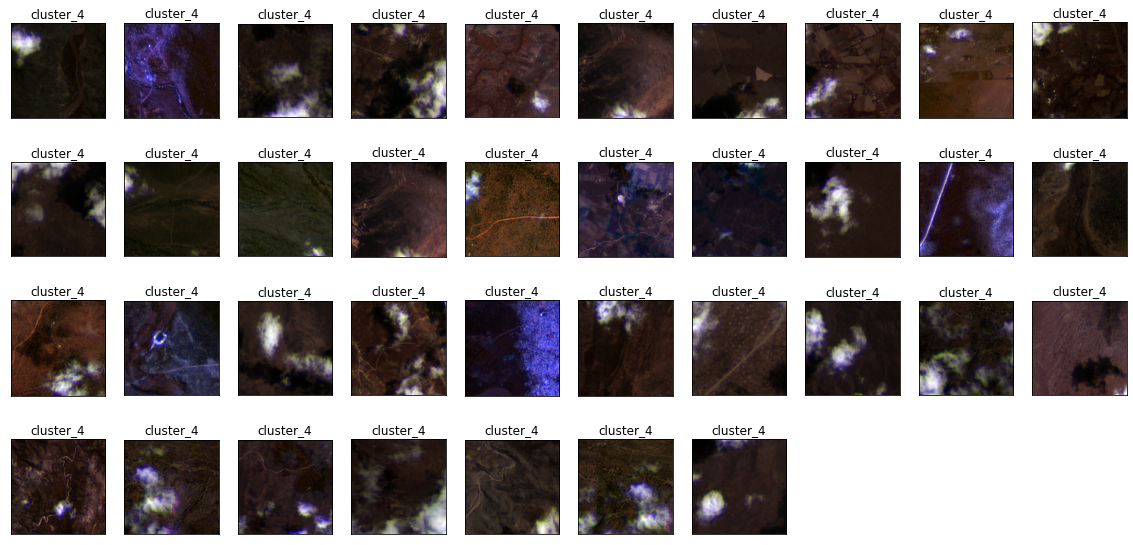

In [29]:
c_path = '/content/drive/My Drive/Clusters_6/cluster_4/'
fig = plt.figure(figsize=(20,20))

images_4 = [file for file in os.listdir(c_path)]

print("Number of images in cluster_4 =", len(images_4))

for cnt, data in enumerate(images_4):
#     print(data)
    y = fig.add_subplot(8, 10, cnt+1)
    img = mpimg.imread(c_path+data)
    y.imshow(img)
    plt.title('cluster_4')
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)

Number of images in cluster_5 = 45


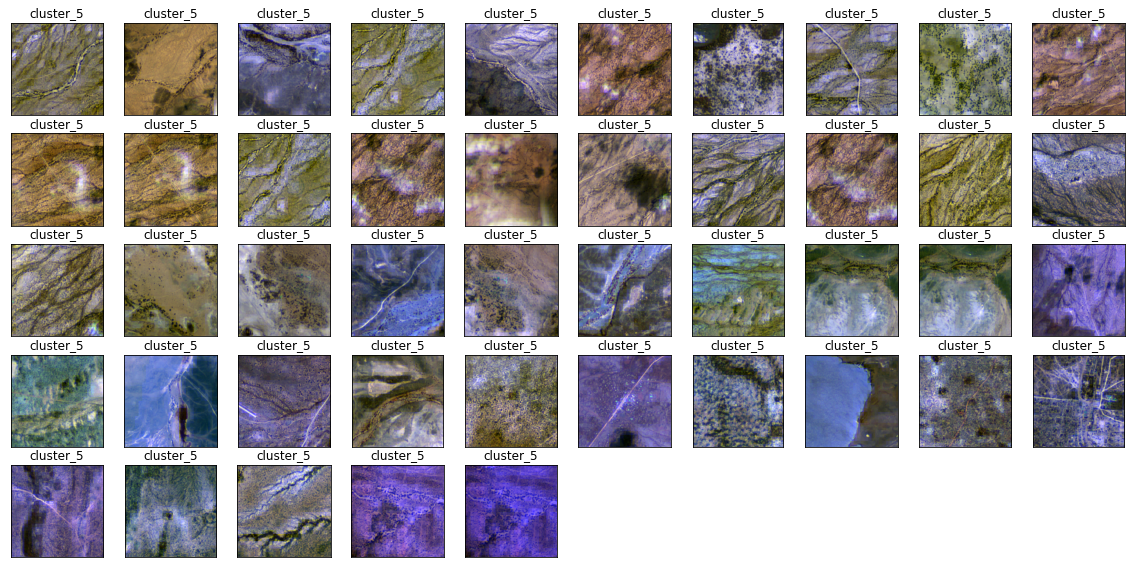

In [30]:
c_path = '/content/drive/My Drive/Clusters_6/cluster_5/'
fig = plt.figure(figsize=(20,20))

images_5 = [file for file in os.listdir(c_path)]

print("Number of images in cluster_5 =", len(images_5))

for cnt, data in enumerate(images_5):
#     print(data)
    y = fig.add_subplot(10, 10, cnt+1)
    img = mpimg.imread(c_path+data)
    y.imshow(img)
    plt.title('cluster_5')
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)